<a href="https://colab.research.google.com/github/031wnstjd/Deep-Learning/blob/master/DL_13_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL_13-GAN

In [1]:
name = input("Name :")
ID = input("student ID :")

Name :추준성
student ID :2016145028


## Prepare

In [ ]:
import numpy as np
import time

import matplotlib.pyplot as plt
import torchvision.utils

import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable, grad
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

### Data Load with augmnetation

In [ ]:
#load dataset	
dataset = 'mnist'
resolution = 32
batch_size = 64
num_workers = 1

transform = transforms.Compose([transforms.Resize(resolution),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

if dataset == 'cifar10':
  dataset = datasets.CIFAR10(root='./data/Cifar10', train=True, download=True, transform=transform)
  data_dim = 3

elif dataset == 'mnist':
  dataset = datasets.MNIST(root='./data/MNIST', train=True, download=True, transform=transform)
  data_dim = 1

train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, num_workers = num_workers)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



### utils

1. model weight initialization

In [ ]:
def initialize_weights(net):
	for m in net.modules():
		if isinstance(m, nn.Conv2d):
			m.weight.data.normal_(0, 0.02)
			if m.bias is not None:
				m.bias.data.zero_()
		elif isinstance(m, nn.ConvTranspose2d):
			m.weight.data.normal_(0, 0.02)
			if m.bias is not None:
				m.bias.data.zero_()
		elif isinstance(m, nn.Conv3d):
			nn.init.xavier_uniform(m.weight)
		elif isinstance(m, nn.ConvTranspose3d):
			nn.init.xavier_uniform(m.weight)
		#elif isinstance(m, nn.GRU):
		#	nn.init.xavier_uniform(m.weight)
		elif isinstance(m, nn.Linear):
			m.weight.data.normal_(0, 0.02)
			m.bias.data.zero_()

2. for image

In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img): # image visualization (input = image)
    plt.ion()
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_images(Generator, fixed_z): # generated image visualization (input = model(G) and latent vector)
    Generator.eval()
    with torch.no_grad():
        # sample latent vectors from the standard normal distribution
        fake_image_batch = Generator(fixed_z)
        fake_image_batch = fake_image_batch.cpu()

        fig, ax = plt.subplots(figsize=(8, 8))
        show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
        plt.show()
    Generator.train(True)

## Model

### Generator

In [ ]:
class Gen(nn.Module):
	def __init__(self, output_dim):
		super(Gen, self).__init__()
		self.input_dim = 100
		self.output_dim = output_dim

		self.deconv = nn.Sequential(
			# 1 -> 4
			nn.Conv2d(100, 256, 4, 1, 3, bias=False),
			nn.BatchNorm2d(256),
			nn.ReLU(),

			# 4 -> 8
			nn.Upsample(scale_factor=2, mode='nearest'),
			nn.Conv2d(256, 128, 3, 1, 1, bias=False),
			nn.BatchNorm2d(128),
			nn.ReLU(),

			# 8 -> 16
			nn.Upsample(scale_factor=2, mode='nearest'),
			nn.Conv2d(128, 64, 3, 1, 1, bias=False),
			nn.BatchNorm2d(64),
			nn.ReLU(),

			#16 -> 32
			nn.Upsample(scale_factor=2, mode='nearest'),
			nn.Conv2d(64, self.output_dim, 3, 1, 1, bias=False),
			nn.Tanh(),
			
		)
	
		initialize_weights(self)

	def forward(self, z):
		x = z.view(-1, self.input_dim, 1, 1)
		x = self.deconv(x)
		return x

## Discriminator

In [ ]:
class Dis(nn.Module):
	def __init__(self, input_dim):
		super(Dis, self).__init__()
		self.input_dim = input_dim
		self.output_dim  = 1 # Real or Fake

		self.conv = nn.Sequential(
			# 32 ->16
			nn.Conv2d(self.input_dim, 64, 4, 2, 1, bias=False),
			nn.BatchNorm2d(64),
			nn.LeakyReLU(0.2),
		)

		self.fc = nn.Sequential(
			nn.Linear(64*16*16, 512),
			nn.BatchNorm1d(512),
			nn.LeakyReLU(0.2),

			nn.Linear(512, 256),
			nn.BatchNorm1d(256),
			nn.LeakyReLU(0.2),

			nn.Linear(256, self.output_dim),
			nn.Sigmoid(),
		)
	
		initialize_weights(self)

	def forward(self, input):
		x = self.conv(input)
		x = self.fc(x.view(-1,64*16*16))
		#x = x.view(x.size(0))
		return x

## Adversarial Training

Hyperparameter

In [ ]:
total_epoch = 10

beta1 = 0.5
beta2 = 0.999
lrG = 0.00005 #0.0002
lrD = 0.00005 #0.0002


Model & Optimizer & Loss

In [ ]:
#construct model G & D
Generator = Gen(data_dim)
Discriminator = Dis(data_dim)

#define optimizer for G & D
G_optimizer = optim.Adam(Generator.parameters(), lr=lrG, betas=(beta1, beta2))
D_optimizer = optim.Adam(Discriminator.parameters(), lr=lrD, betas=(beta1, beta2))


Generator = Generator.cuda()
Discriminator = Discriminator.cuda()
BCE_loss = nn.BCELoss().cuda() #BCELoss : Binary Cross Entropy Loss

Training

Dataset Length  60000
[E000]  G_loss :  0.694547   D_loss :  1.397601 = 0.674007 + 0.723595
[E000]  G_loss :  0.704727   D_loss :  1.325682 = 0.662268 + 0.663414
[E000]  G_loss :  0.695908   D_loss :  1.316328 = 0.657705 + 0.658623
[E000]  G_loss :  0.695943   D_loss :  1.311463 = 0.673003 + 0.638460
[E000]  G_loss :  0.694967   D_loss :  1.294282 = 0.659381 + 0.634901
[E000]  G_loss :  0.718534   D_loss :  1.302677 = 0.650861 + 0.651816
[E000]  G_loss :  0.718043   D_loss :  1.289850 = 0.649203 + 0.640647
[E000]  G_loss :  0.713842   D_loss :  1.289213 = 0.644822 + 0.644391
[E000]  G_loss :  0.700519   D_loss :  1.264578 = 0.647767 + 0.616811
[E000]  G_loss :  0.720776   D_loss :  1.288189 = 0.644991 + 0.643198


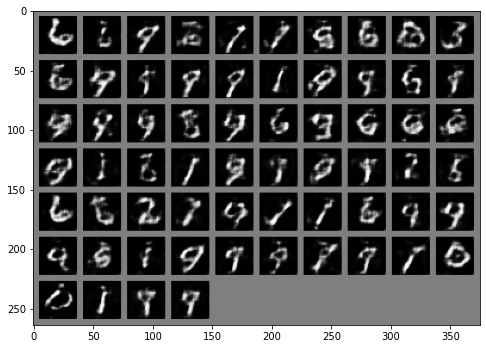

[E001]  G_loss :  0.717992   D_loss :  1.258692 = 0.644046 + 0.614645
[E001]  G_loss :  0.723603   D_loss :  1.263075 = 0.637413 + 0.625662
[E001]  G_loss :  0.743263   D_loss :  1.236077 = 0.616580 + 0.619497
[E001]  G_loss :  0.692956   D_loss :  1.255416 = 0.655428 + 0.599988
[E001]  G_loss :  0.720681   D_loss :  1.258811 = 0.623060 + 0.635750
[E001]  G_loss :  0.766015   D_loss :  1.214891 = 0.593671 + 0.621220
[E001]  G_loss :  0.723934   D_loss :  1.242823 = 0.619442 + 0.623382
[E001]  G_loss :  0.706355   D_loss :  1.237180 = 0.635941 + 0.601239
[E001]  G_loss :  0.725380   D_loss :  1.225373 = 0.616918 + 0.608455
[E001]  G_loss :  0.743496   D_loss :  1.225835 = 0.604901 + 0.620934


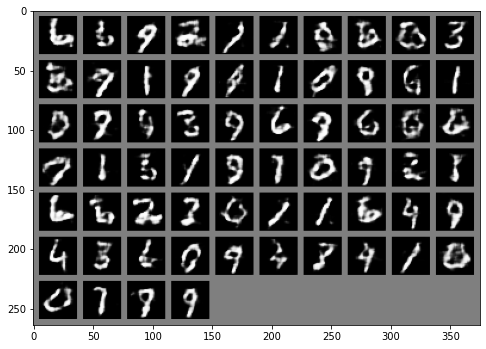

[E002]  G_loss :  0.701711   D_loss :  1.228857 = 0.601396 + 0.627461
[E002]  G_loss :  0.741866   D_loss :  1.239308 = 0.618033 + 0.621275
[E002]  G_loss :  0.748815   D_loss :  1.181090 = 0.576336 + 0.604754
[E002]  G_loss :  0.682862   D_loss :  1.242927 = 0.618007 + 0.624920
[E002]  G_loss :  0.714326   D_loss :  1.165123 = 0.592613 + 0.572510
[E002]  G_loss :  0.741119   D_loss :  1.286544 = 0.599382 + 0.687162
[E002]  G_loss :  0.761567   D_loss :  1.179332 = 0.568545 + 0.610787
[E002]  G_loss :  0.725980   D_loss :  1.227316 = 0.605368 + 0.621949
[E002]  G_loss :  0.731026   D_loss :  1.149052 = 0.581694 + 0.567358
[E002]  G_loss :  0.730519   D_loss :  1.153534 = 0.586638 + 0.566896


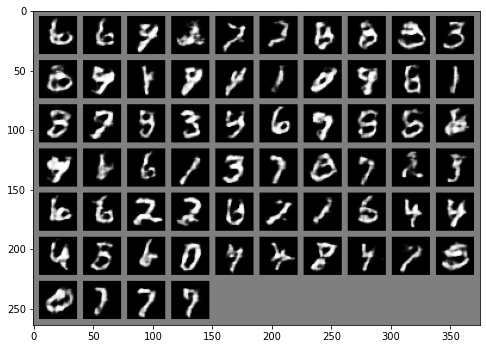

[E003]  G_loss :  0.727979   D_loss :  1.173915 = 0.581722 + 0.592193
[E003]  G_loss :  0.742904   D_loss :  1.142796 = 0.566690 + 0.576106
[E003]  G_loss :  0.731411   D_loss :  1.175108 = 0.611261 + 0.563847
[E003]  G_loss :  0.720391   D_loss :  1.166820 = 0.578338 + 0.588482
[E003]  G_loss :  0.701090   D_loss :  1.183735 = 0.593753 + 0.589982
[E003]  G_loss :  0.709565   D_loss :  1.216925 = 0.589553 + 0.627373
[E003]  G_loss :  0.747046   D_loss :  1.239126 = 0.599815 + 0.639311
[E003]  G_loss :  0.698725   D_loss :  1.149230 = 0.592185 + 0.557045
[E003]  G_loss :  0.763607   D_loss :  1.176699 = 0.572909 + 0.603790
[E003]  G_loss :  0.720143   D_loss :  1.207850 = 0.601954 + 0.605896


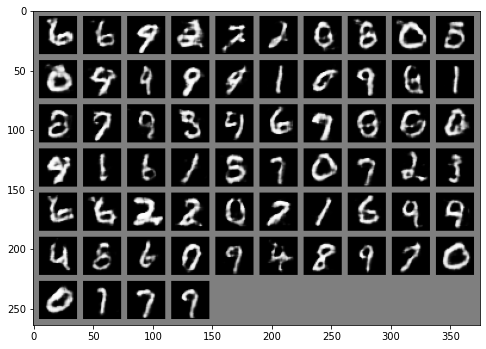

[E004]  G_loss :  0.757837   D_loss :  1.179323 = 0.581633 + 0.597690
[E004]  G_loss :  0.744336   D_loss :  1.185085 = 0.589121 + 0.595964
[E004]  G_loss :  0.744192   D_loss :  1.159945 = 0.570024 + 0.589922
[E004]  G_loss :  0.808084   D_loss :  1.159779 = 0.527693 + 0.632086
[E004]  G_loss :  0.704806   D_loss :  1.125584 = 0.578509 + 0.547075
[E004]  G_loss :  0.686492   D_loss :  1.167091 = 0.619554 + 0.547537
[E004]  G_loss :  0.717665   D_loss :  1.183591 = 0.618911 + 0.564681
[E004]  G_loss :  0.738390   D_loss :  1.222667 = 0.568342 + 0.654325
[E004]  G_loss :  0.714958   D_loss :  1.176538 = 0.614669 + 0.561869
[E004]  G_loss :  0.721946   D_loss :  1.110587 = 0.562154 + 0.548433


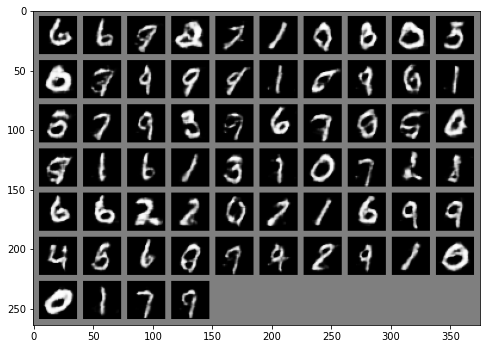

[E005]  G_loss :  0.650183   D_loss :  1.123181 = 0.606466 + 0.516714
[E005]  G_loss :  0.710228   D_loss :  1.219106 = 0.642595 + 0.576511
[E005]  G_loss :  0.686313   D_loss :  1.076612 = 0.568002 + 0.508610
[E005]  G_loss :  0.703796   D_loss :  1.084347 = 0.557331 + 0.527016
[E005]  G_loss :  0.804157   D_loss :  1.077764 = 0.525292 + 0.552472
[E005]  G_loss :  0.682565   D_loss :  1.148298 = 0.599956 + 0.548342
[E005]  G_loss :  0.702612   D_loss :  1.113495 = 0.585626 + 0.527869
[E005]  G_loss :  0.725363   D_loss :  1.096309 = 0.554408 + 0.541901
[E005]  G_loss :  0.720618   D_loss :  1.131437 = 0.572198 + 0.559239
[E005]  G_loss :  0.756119   D_loss :  1.027644 = 0.546576 + 0.481068


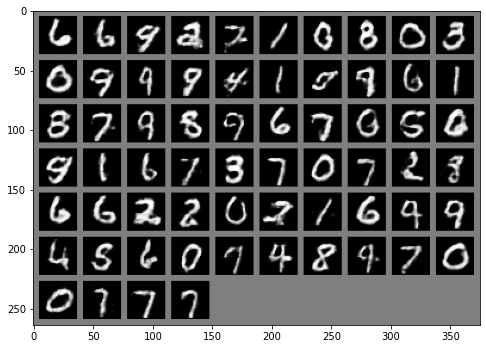

[E006]  G_loss :  0.720786   D_loss :  1.113358 = 0.605654 + 0.507704
[E006]  G_loss :  0.700521   D_loss :  1.067205 = 0.571735 + 0.495470
[E006]  G_loss :  0.747351   D_loss :  1.086578 = 0.539363 + 0.547215
[E006]  G_loss :  0.772544   D_loss :  1.081264 = 0.531914 + 0.549350
[E006]  G_loss :  0.778658   D_loss :  1.088053 = 0.534045 + 0.554008
[E006]  G_loss :  0.781757   D_loss :  1.168709 = 0.523855 + 0.644854
[E006]  G_loss :  0.757858   D_loss :  1.062701 = 0.505885 + 0.556816
[E006]  G_loss :  0.736300   D_loss :  1.155791 = 0.601652 + 0.554139
[E006]  G_loss :  0.787834   D_loss :  1.136196 = 0.541018 + 0.595178
[E006]  G_loss :  0.767597   D_loss :  1.172405 = 0.547361 + 0.625044


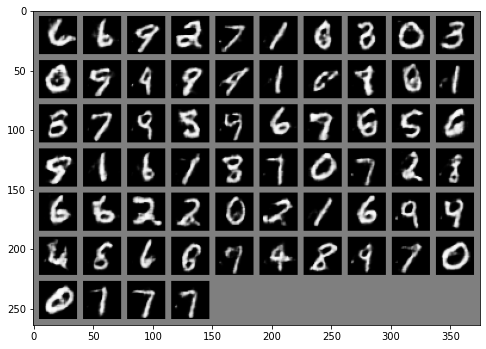

[E007]  G_loss :  0.750238   D_loss :  1.078350 = 0.539331 + 0.539019
[E007]  G_loss :  0.760768   D_loss :  1.010167 = 0.529679 + 0.480488
[E007]  G_loss :  0.778412   D_loss :  1.080005 = 0.552123 + 0.527882
[E007]  G_loss :  0.709929   D_loss :  1.032334 = 0.545586 + 0.486749
[E007]  G_loss :  0.716320   D_loss :  1.119344 = 0.576886 + 0.542458
[E007]  G_loss :  0.802794   D_loss :  1.012311 = 0.476683 + 0.535628
[E007]  G_loss :  0.738577   D_loss :  1.089636 = 0.518885 + 0.570751
[E007]  G_loss :  0.721150   D_loss :  1.113736 = 0.606732 + 0.507004
[E007]  G_loss :  0.756127   D_loss :  1.026032 = 0.520700 + 0.505332
[E007]  G_loss :  0.711752   D_loss :  1.080535 = 0.529615 + 0.550920


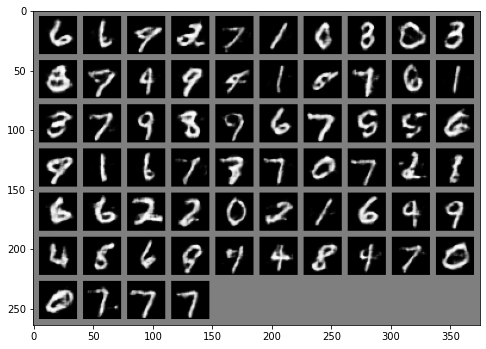

[E008]  G_loss :  0.656426   D_loss :  1.093266 = 0.576446 + 0.516820
[E008]  G_loss :  0.770423   D_loss :  1.082155 = 0.502295 + 0.579860
[E008]  G_loss :  0.731994   D_loss :  1.038596 = 0.551957 + 0.486639
[E008]  G_loss :  0.693398   D_loss :  1.086919 = 0.585021 + 0.501898
[E008]  G_loss :  0.762258   D_loss :  1.120277 = 0.533675 + 0.586602
[E008]  G_loss :  0.827694   D_loss :  0.999560 = 0.503515 + 0.496045
[E008]  G_loss :  0.814139   D_loss :  1.065774 = 0.493225 + 0.572549
[E008]  G_loss :  0.783448   D_loss :  1.107054 = 0.540950 + 0.566104
[E008]  G_loss :  0.707269   D_loss :  1.051685 = 0.511487 + 0.540198
[E008]  G_loss :  0.740913   D_loss :  1.081548 = 0.517472 + 0.564076


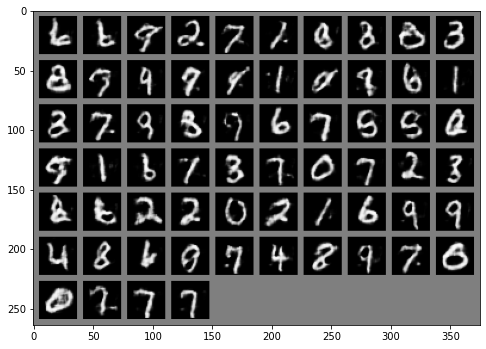

[E009]  G_loss :  0.696526   D_loss :  1.115197 = 0.516491 + 0.598706
[E009]  G_loss :  0.796407   D_loss :  1.074101 = 0.505521 + 0.568580
[E009]  G_loss :  0.795857   D_loss :  1.031528 = 0.499665 + 0.531863
[E009]  G_loss :  0.792887   D_loss :  1.014109 = 0.515643 + 0.498466
[E009]  G_loss :  0.699006   D_loss :  1.129461 = 0.604644 + 0.524817
[E009]  G_loss :  0.802465   D_loss :  1.102516 = 0.518626 + 0.583891
[E009]  G_loss :  0.673704   D_loss :  1.069542 = 0.574706 + 0.494836
[E009]  G_loss :  0.770960   D_loss :  1.056677 = 0.521695 + 0.534982
[E009]  G_loss :  0.781350   D_loss :  1.001036 = 0.485088 + 0.515948
[E009]  G_loss :  0.734458   D_loss :  1.142178 = 0.594065 + 0.548113


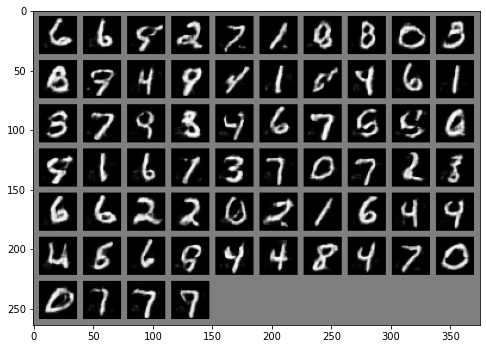

In [ ]:

y_real_, y_fake_ = Variable(torch.ones(batch_size, 1).cuda()), Variable(torch.zeros(batch_size, 1).cuda())
fixed_z = Variable(torch.rand(batch_size, 100).cuda())


#train start!
Discriminator.train()
start_time = time.time()

print("Dataset Length ", train_loader.dataset.__len__())

for epoch in range(total_epoch):
  Generator.train()
  epoch_start_time = time.time()

  for iB, (img_,_) in enumerate(train_loader):
    if iB == train_loader.dataset.__len__() // batch_size:
      break

    #Latent space
    ## z_ -> ( batch_size x 100 ) uniform distribution / randn_ : normal gaussian distribution
    z_ = torch.rand(batch_size, 100)
      
    z_, img_ = Variable(z_.cuda()), Variable(img_.cuda())
  

    #----Update D_network----#
    D_optimizer.zero_grad()

    D_real = Discriminator(img_)
    D_real_loss = BCE_loss(D_real, y_real_)
      
    fake_img_ = Generator(z_)
    D_fake = Discriminator(fake_img_)
    D_fake_loss = BCE_loss(D_fake, y_fake_)

    D_loss = D_fake_loss + D_real_loss
    D_loss.backward()

    # ***only for train very well***#
    num_real_correct = torch.sum(D_real > 0.5)
    num_fake_correct = torch.sum(D_fake < 0.5)
    D_acc = float(num_real_correct.item() + num_fake_correct.item()) / (batch_size*2)
    if D_acc < 0.8:
      D_optimizer.step()		
    # ***only for train very well***#


    #----Update G_network----#
    for itr in range(3):
      G_optimizer.zero_grad()	
      G_ = Generator(z_)
  
      D_fake = Discriminator(G_)
      G_loss = BCE_loss(D_fake, y_real_)
  
      G_loss.backward()
      G_optimizer.step()

    #---check train result ----#
    if(iB % 100 == 0) and (epoch%1==0):
      print('[E%03d]'%(epoch)+'  G_loss :  %.6f '%(G_loss.item())+'  D_loss :  %.6f = %.6f + %.6f'%(D_loss.item(), D_fake_loss.item(), D_real_loss.item()))
  
  show_images(Generator, fixed_z)
  Generator.train()
      